# Pump Theory and Performance

First, we will import the necessary packages to solve the problems.

In [1]:
import pandas as pd
from fluids import friction, core, fittings
from fluids.piping import nearest_pipe
from pyfluids import Fluid, FluidsList, Input
import numpy as np
from scipy.optimize import root_scalar
from plotly.subplots import make_subplots
from scipy.interpolate import interp1d

pd.options.plotting.backend = "plotly"

## 1. Pump analysis using the Euler's equation and velocity triangle 
Given the following data for a centrifugal water pump, estimate 
- the design point discharge
- the power delivered to the water
- the head

Given:
- Radius at inlet and outlet: 0.1m 0.175m
- Blade angle at inlet and outlet: \\(30^o\\), \\(20^o\\)
- Impeller speed: 1440 revolution per min (RPM)
- Impeller width at inlet and outlet: 4.25cm

<p style="text-align: center;">
============== Answer ==============
</p>

Let's assume that there is no rotation in the inlet water. Therefore, the velocity triangle at the inlet will look like following:

<p style="text-align: center;">
  <img src="../docs/src/img/pump_analysis_inlet_triangle1.png" alt="Inlet velocity triangle" width=200>
</p>

Then, the discharge rate can be obtained as such:

Velocities:
	 u1 = 15.08 m/s 
	 v1 = 8.71 m/s


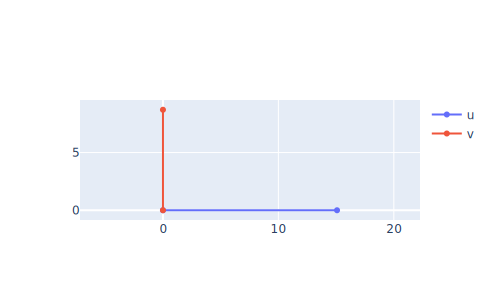

Flow rate: 837.0 m3/h


In [2]:
water = Fluid(FluidsList.Water).with_state(
    Input.pressure(1e5), Input.temperature(20)
)
inlet_impeller_radius_m = 0.10
outlet_impeller_radius_m = 0.175
inlet_blade_angle_deg = 30
outlet_blade_angle_deg = 20
impeller_rotation_speed_rpm = 1440
impeller_width_m = 0.0425

# First convert the values to SI units
impeller_rotation_speed_rad_per_s = 1440 / 60 * 2 * np.pi

# Calculate the velocities
u1 = impeller_rotation_speed_rad_per_s * inlet_impeller_radius_m
v1 = u1 * np.tan(np.deg2rad(inlet_blade_angle_deg))
print(f"Velocities:\n\t u1 = {u1:.2f} m/s \n\t v1 = {v1:.2f} m/s")

# Plot the velocity triangle
def plot_velocity_triangle(u, v, alpha_deg, beta_deg):
    fig = make_subplots()
    fig.add_scatter(x=[0, u], y=[0, 0], name="u")
    alpha_rad = np.deg2rad(alpha_deg)
    fig.add_scatter(x=[0, v * np.cos(alpha_rad)], y=[0, v * np.sin(alpha_rad)], name="v")
    fig.update_layout(height=300, width=500)
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.show(renderer="svg")

plot_velocity_triangle(
    u=u1, 
    v=v1, 
    alpha_deg=90,
    beta_deg=inlet_blade_angle_deg
)

# Calculate the flow rate
def get_flow_impeller_m3_per_s(radial_velocity_m_per_s, width_m, radius_m):
    return 2 * np.pi * radius_m * width_m * radial_velocity_m_per_s

flow_rate_m3_per_s = get_flow_impeller_m3_per_s(
    radial_velocity_m_per_s=v1,
    width_m=impeller_width_m,
    radius_m=inlet_impeller_radius_m
)
print(f"Flow rate: {flow_rate_m3_per_s * 3600:.1f} m3/h")


The velocity triangle can be drawn for the outlet from the given conditions. The radial velocity \\(V_n2\\) can be determined from flow rate calculated.

<p style="text-align: center;">
  <img src="../docs/src/img/pump_analysis_outlet_triangle1.png" alt="Inlet velocity triangle" width=200>
</p>

Power: 77904.01 W


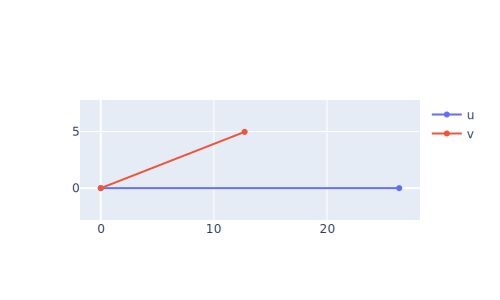

In [3]:
u2 = outlet_impeller_radius_m * impeller_rotation_speed_rad_per_s
area_outlet_m2 = 2 * np.pi * outlet_impeller_radius_m * impeller_width_m
v_n2 = flow_rate_m3_per_s / area_outlet_m2
v_t2 = u2 - v_n2 / np.tan(np.deg2rad(outlet_blade_angle_deg))
power = water.density * flow_rate_m3_per_s * (u2 * v_t2) 
print(f"Power: {power:.2f} W")

alpha = np.degrees(np.arctan(v_n2 / v_t2))
v2 = np.sqrt(v_n2**2 + v_t2**2)
plot_velocity_triangle(u=u2, v=v2, alpha_deg=alpha, beta_deg=outlet_blade_angle_deg)

The head can be estimated the assumption that there is no flow or energy loss in the impeller.

In [4]:
gravitational_acc_m2_per_s = 9.81
head = power / (water.density * gravitational_acc_m2_per_s * flow_rate_m3_per_s)
print(f"Head is {head:.1f} m")

Head is 34.2 m


As we have seen, we usually ignore the tangential velocity of the inlet flow. Then,

$$
P_w = \rho Q u_2 V_{t2}
$$

where

$$
V_{t2} = u_2 - V_{n2} cot \beta_2 \quad V_{n2} = \frac{Q}{2\pi r_2 b_2}
$$

From, the above we get

$$
H\approx \frac{u_2^2}{g} - \frac{u_2 \cot \beta_2}{2 \pi r_2 b_2 g}Q
$$


## 2. Pump performance curve and calculating the power consumption

Given the following pump performance curve, estimate the power consumption for flows.

| Flow [m3/h] | head [m] | efficiency | NPSH_r |
|------------:|---------:|-----------:|-------:|
|           0 |      207 |          0 |
|         250 |      204 |       0.23 |
|         500 |      200 |       0.41 |
|         750 |      195 |       0.54 |
|        1000 |      189 |       0.65 |
|        1250 |      182 |       0.72 |
|        1500 |      174 |       0.77 |
|        1750 |      165 |       0.80 |
|        2000 |      152 |       0.79 |

The fluid is water at ambient temperature.

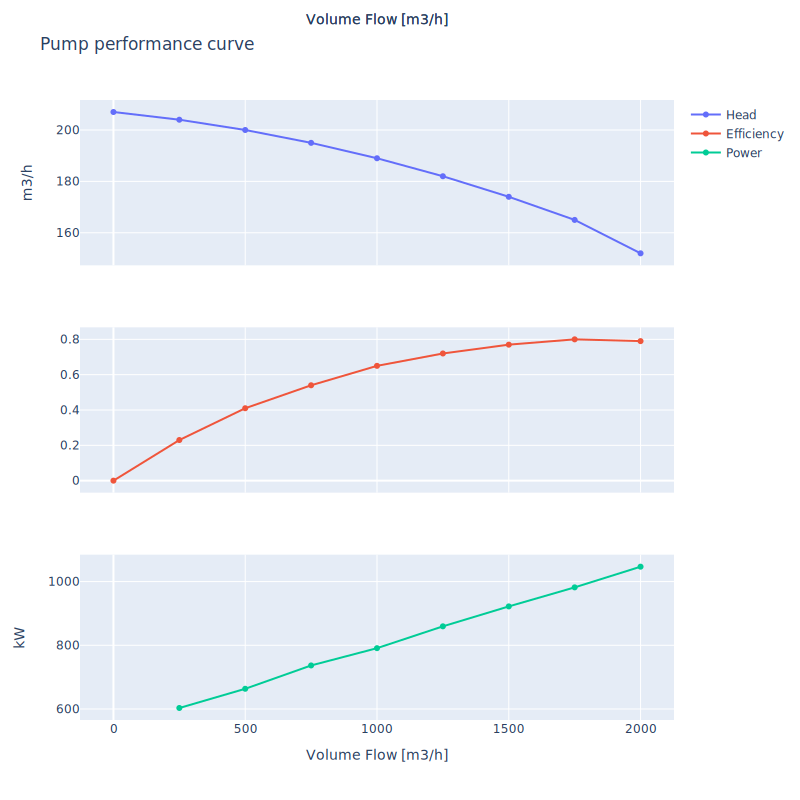

In [5]:
fluid = Fluid(FluidsList.Water).with_state(Input.pressure(1e5), Input.temperature(20))

df = pd.DataFrame()
df["Flow [m3/h]"] = np.array([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000])
df["Head [m]"] = np.array([207, 204, 200, 195, 189, 182, 174, 165, 152])
df["Efficiency"] = np.array([0, 0.23, 0.41, 0.54, 0.65, 0.72, 0.77, 0.80, 0.79])
df["Power [kW]"] = \
    fluid.density * gravitational_acc_m2_per_s \
    * df["Flow [m3/h]"] / 3600 \
    * df["Head [m]"] \
    / df["Efficiency"] \
    / 1000

fig = make_subplots(cols=1, rows=3, shared_xaxes=True)
fig.add_scatter(x=df["Flow [m3/h]"], y=df["Head [m]"], name="Head", col=1, row=1)
fig.add_scatter(x=df["Flow [m3/h]"], y=df["Efficiency"], name="Efficiency", col=1, row=2)
fig.add_scatter(x=df["Flow [m3/h]"], y=df["Power [kW]"], name="Power", col=1, row=3)
fig.update_layout(title="Pump performance curve", width=800, height=800)
fig.update_xaxes(title="Volume Flow [m3/h]")
fig.update_yaxes(col=1, row=1, title="m3/h")
fig.update_yaxes(col=1, row=3, title="kW")
fig.show(renderer="svg")

## 3. Pump Operating Point

For the pump given above, find the operating of the pump and the power consumption.

### a. When the piping system is given as belows:
- nominal diameter: 400A
- pipe material: stainless steel
- schedule: 40s
- length: 200m
- k value for fittings: 20

First let's look at our system. We can think of two different causalities for the system.
The first one is the flow is determined at pump whereas the pressure is determined in the branch or the piping system.
The other one is vice versa. Depending on the causalities we choose, the way to solve the equation will be
different. It is numerically less challenging and simpler to choose the first causality. It is physically natural also.

<p style="text-align: center">
    <img src="../img/03_Centrifugal_Pump_Performance_Pump_System.png" alt="Pumping system" width="400">
</p>


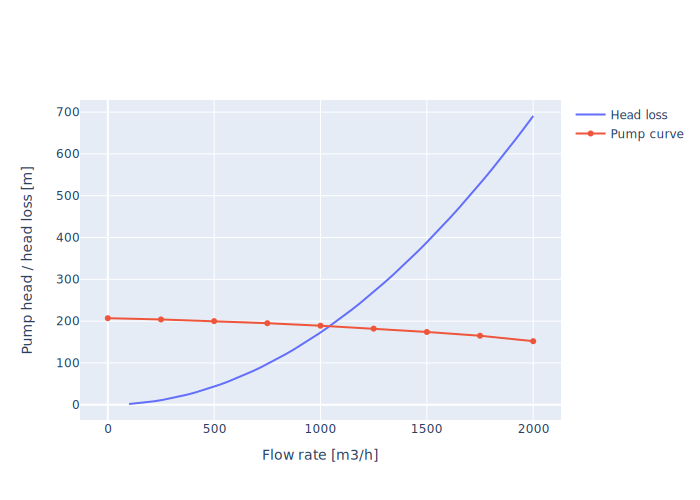

In [6]:
# We are given
nom_dia_m = 0.20
pipe_material = "clean stainless steel pipe"
schedule = "40S"
length_m = 200
k_value_fittings = 20
roughness = friction.material_roughness(pipe_material)

# Define a function to get pump efficiency by interpolation
interpolate_function_for_efficiency = interp1d(
    x=df["Flow [m3/h]"] / 3600, y=df["Efficiency"], kind="cubic"
)
def get_pump_efficiency(flow_m3_per_s: float) -> float:
    return interpolate_function_for_efficiency(flow_m3_per_s)

# We will define the function for the pressure drop for the branch
def get_head_loss_with_flow_input(flow_m3_per_s: float, nom_dia_m: float) -> float:
    """Returns the head loss from given the flow rate"""
    _, inner_dia_m, _, _ = nearest_pipe(Di=nom_dia_m, schedule=schedule)
    pipe_section_area = np.pi * inner_dia_m**2 / 4
    velocity_m_per_s = flow_m3_per_s / pipe_section_area
    pressure_drop_fitting = core.dP_from_K(
        K=k_value_fittings, rho=fluid.density, V=velocity_m_per_s
    )
    pressure_drop_pipe = friction.one_phase_dP(
        m=flow_m3_per_s * fluid.density,
        rho=fluid.density,
        mu=fluid.dynamic_viscosity,
        D=inner_dia_m,
        roughness=roughness,
        L=length_m
    )
    return (pressure_drop_pipe + pressure_drop_fitting) \
           / (fluid.density * gravitational_acc_m2_per_s)

# We will define the function for flow for the given head of the
df.sort_values(by="Head [m]", inplace=True)
interpolate_function = interp1d(
    x=df["Head [m]"], y=df["Flow [m3/h]"] / 3600, kind="cubic", fill_value="extrapolate"
)
def get_flow_pump_m3_per_s(head_m: float) -> float:
    """Returns the flow of the pump from given the head"""
    return interpolate_function(head_m)

# Let's plot the head loss in the piping system on the pump curve
fig = make_subplots()
flow_array_m3_per_h = np.linspace(100, df["Flow [m3/h]"].max())
head_loss_array_m = np.array([
    get_head_loss_with_flow_input(flow_m3_per_s=each_flow/3600, nom_dia_m=nom_dia_m)
    for each_flow in flow_array_m3_per_h
])
fig.add_scatter(x=flow_array_m3_per_h, y=head_loss_array_m, name="Head loss")
fig.add_scatter(x=df["Flow [m3/h]"], y=df["Head [m]"], name="Pump curve")
fig.update_xaxes(title="Flow rate [m3/h]")
fig.update_yaxes(title="Pump head / head loss [m]")
fig.show(renderer="svg")

In [7]:
# Let's find the flow rate that satisfies both the pump curve and friction loss curve.
def function_to_solve(flow_m3_per_s: float) -> float:
    """Function to solve the flow for the problem"""
    head_loss = get_head_loss_with_flow_input(flow_m3_per_s=flow_m3_per_s, nom_dia_m=nom_dia_m)
    pump_flow_m3_per_s = get_flow_pump_m3_per_s(head_loss)
    return flow_m3_per_s - pump_flow_m3_per_s
x0 = 1000 / 3600
x1 = 1010 / 3600
sol = root_scalar(f=function_to_solve, x0=x0, x1=x1)
head_pump_m = get_head_loss_with_flow_input(flow_m3_per_s=sol.root, nom_dia_m=nom_dia_m)
efficiency = get_pump_efficiency(sol.root)
power_one_pump_w = fluid.density \
                   * gravitational_acc_m2_per_s \
                   * head_pump_m \
                   * sol.root \
                   / efficiency
print(f"The flow will be {sol.root * 3600:.1f} m3/h")
print(f"The head at the outlet of the pump will be {head_pump_m} m")
print(f"The efficiency is {efficiency:.3f}")
print(f"The power is {power_one_pump_w / 1000:.0f} kW")

The flow will be 1042.7 m3/h
The head at the outlet of the pump will be 187.87462245305443 m
The efficiency is 0.665
The power is 802 kW


### b. We found that the flow is less than expected. One enginner suggested to add an identical pump in parallel to the system. What will be the estimated flow and head with the new configuration?

Now we have a new system.

<p style="text-align: center">
    <img src="../img/03_Centrifugal_Pump_Performance_Pump_System_Two_Pumps.jpg" alt="Pumping system" width="400">
</p>

From the causality above, we now know that will have the same head when operating in parallel. Then we can draw our curves for the total flow.


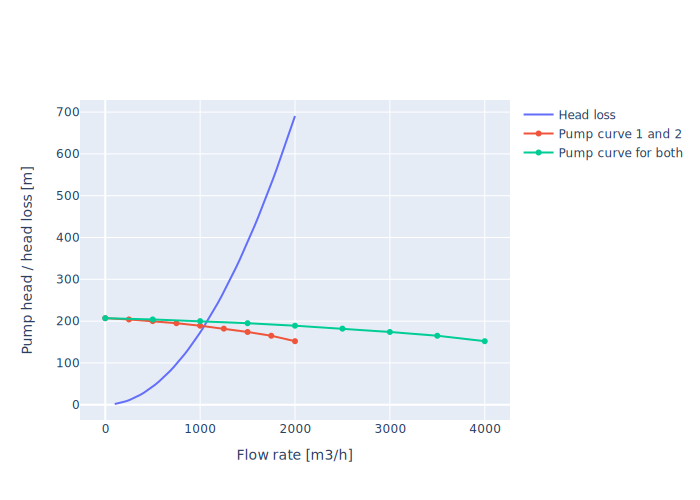

In [8]:
fig = make_subplots()
flow_array_m3_per_h = np.linspace(100, df["Flow [m3/h]"].max())
head_loss_array_m = np.array([
    get_head_loss_with_flow_input(flow_m3_per_s=each_flow/3600, nom_dia_m=nom_dia_m)
    for each_flow in flow_array_m3_per_h
])
fig.add_scatter(x=flow_array_m3_per_h, y=head_loss_array_m, name="Head loss")
fig.add_scatter(x=df["Flow [m3/h]"], y=df["Head [m]"], name="Pump curve 1 and 2")
fig.add_scatter(x=df["Flow [m3/h]"] * 2, y=df["Head [m]"], name="Pump curve for both")
fig.update_xaxes(title="Flow rate [m3/h]")
fig.update_yaxes(title="Pump head / head loss [m]")
fig.show(renderer="svg")

In [9]:
def get_pumps_flow_m3_per_s(head_m: float) -> float:
    return get_flow_pump_m3_per_s(head_m) * 2

def function_to_solve(vol_flow_m3_per_s) -> float:
    """Function to solve the problem"""
    head_m = get_head_loss_with_flow_input(flow_m3_per_s=vol_flow_m3_per_s, nom_dia_m=nom_dia_m)
    pump_flow = get_pumps_flow_m3_per_s(head_m)
    return vol_flow_m3_per_s - pump_flow

x0 = 1040 / 3600
x1 = 1050 / 3600
sol = root_scalar(f=function_to_solve, x0=x0, x1=x1)
flow_m3_per_s = sol.root
head_pump_m = get_head_loss_with_flow_input(flow_m3_per_s=flow_m3_per_s, nom_dia_m=nom_dia_m)
flow_for_each_pump_m3_per_s = flow_m3_per_s / 2
efficiency = get_pump_efficiency(flow_for_each_pump_m3_per_s)
power_two_pump_w = fluid.density \
                   * gravitational_acc_m2_per_s \
                   * head_pump_m \
                   * flow_m3_per_s \
                   / efficiency
print(f"The flow will be {sol.root * 3600:.1f} m3/h")
print(f"The head at the outlet of the pump will be {head_pump_m} m")
print(f"The efficiency is {efficiency:.3f}")
print(f"The power is {power_two_pump_w / 1000:.0f} kW")

The flow will be 1074.0 m3/h
The head at the outlet of the pump will be 199.31930760257043 m
The efficiency is 0.432
The power is 1349 kW


### c. What about having the pump in series?

<p style="text-align: center">
    <img src="../img/03_Centrifugal_Pump_Performance_Pump_System_Two_Pumps_Series.jpg" alt="Pumping system" width="400">
</p>

Here, we know that the pumps are identical and should have the same flow. Therefore, the head should be also identical. Therefore,

$$
h_{l} = h_{p1} + h_{p2}
$$
$$
h_{l} = 2 h_{p}
$$

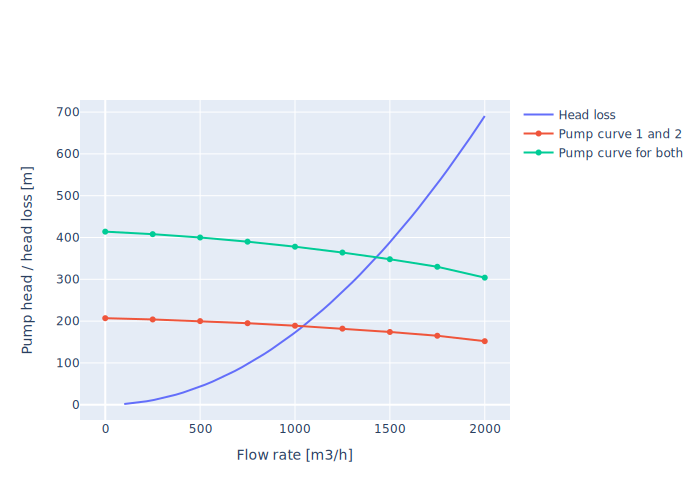

In [10]:
fig = make_subplots()
fig.add_scatter(x=flow_array_m3_per_h, y=head_loss_array_m, name="Head loss")
fig.add_scatter(x=df["Flow [m3/h]"], y=df["Head [m]"], name="Pump curve 1 and 2")
fig.add_scatter(x=df["Flow [m3/h]"], y=df["Head [m]"] * 2, name="Pump curve for both")
fig.update_xaxes(title="Flow rate [m3/h]")
fig.update_yaxes(title="Pump head / head loss [m]")
fig.show(renderer="svg")

In [11]:
def get_pumps_flow_m3_per_s(head_m: float) -> float:
    head_for_each_pump_m = head_m / 2
    return get_flow_pump_m3_per_s(head_for_each_pump_m)

def function_to_solve(vol_flow_m3_per_s) -> float:
    """Function to solve the problem"""
    head_m = get_head_loss_with_flow_input(
        flow_m3_per_s=vol_flow_m3_per_s, nom_dia_m=nom_dia_m
    )
    pump_flow = get_pumps_flow_m3_per_s(head_m)
    return vol_flow_m3_per_s - pump_flow

x0 = 1450 / 3600
x1 = 1460 / 3600
sol = root_scalar(f=function_to_solve, x0=x0, x1=x1)
flow_m3_per_s = sol.root
head_pump_two_pumps_series_m = get_head_loss_with_flow_input(
    flow_m3_per_s=flow_m3_per_s, nom_dia_m=nom_dia_m
)
efficiency = get_pump_efficiency(flow_m3_per_s)
power_two_pump_w = fluid.density \
                   * gravitational_acc_m2_per_s \
                   * head_pump_two_pumps_series_m \
                   * flow_m3_per_s \
                   / efficiency
print(f"The flow will be {sol.root * 3600:.1f} m3/h")
print(f"The head at the outlet of the second pump will be {head_pump_two_pumps_series_m:.1f} m")
print(f"The efficiency is {efficiency:.3f}")
print(f"The power is {power_two_pump_w / 1000:.0f} kW")

The flow will be 1429.1 m3/h
The head at the outlet of the second pump will be 352.7 m
The efficiency is 0.757
The power is 1810 kW


### d. Someone who took this course finally suggests that we should just increase the size of the pipe. How large the pipe should be to have 1429.1m <sup>3</sup>/h flow? What would be power consumption at this size?

In [12]:
# Let's define the head loss function in diameter of the pipe.
head_for_pump_m = head_pump_two_pumps_series_m / 2
def get_head_loss_with_pipe_size_input(inner_dia_m: float) -> float:
    pipe_section_area = np.pi * inner_dia_m**2 / 4
    velocity_m_per_s = flow_m3_per_s / pipe_section_area
    pressure_drop_fitting = core.dP_from_K(
        K=k_value_fittings, rho=fluid.density, V=velocity_m_per_s
    )
    pressure_drop_pipe =  friction.one_phase_dP(
        m=flow_m3_per_s * fluid.density,
        rho=fluid.density,
        mu=fluid.dynamic_viscosity,
        D=inner_dia_m,
        roughness=roughness,
        L=length_m
    )
    return (pressure_drop_fitting + pressure_drop_pipe) \
           / (fluid.density * gravitational_acc_m2_per_s)

def function_to_solve(inner_dia_m: float) -> float:
    return head_for_pump_m - get_head_loss_with_pipe_size_input(inner_dia_m)

sol = root_scalar(f=function_to_solve, x0=nom_dia_m, x1=nom_dia_m*1.1)
inner_dia_m = sol.root
head_pump_m = get_head_loss_with_pipe_size_input(inner_dia_m)
power_increased_dia = fluid.density \
                      * gravitational_acc_m2_per_s \
                      * flow_m3_per_s \
                      * head_pump_m \
                      / efficiency

print(f"The volume flow: {flow_m3_per_s * 3600:.1f} m3/h ")
print(f"The increase diameter should be at least {inner_dia_m * 1000:.1f}mm")
print(f"The head at the outlet of the pump will be {head_pump_m:.1f} m")
print(f"The efficiency is {efficiency:.3f}")
print(f"The power is {power_increased_dia / 1000:.0f} kW")

The volume flow: 1429.1 m3/h 
The increase diameter should be at least 235.1mm
The head at the outlet of the pump will be 176.4 m
The efficiency is 0.757
The power is 905 kW


### e. What is the weight increase to increase the pipe from 200A to 250A?

In [13]:
# weight per length
price_nok_per_kg = 20
density_stainless_steel_kg_per_m3 = 7500
def get_weight_per_length(nominal_dia_m: float, schedule: str):
    """Calculates the weight per length for the pipe"""
    _, inner_dia_m, outer_dia_m, thickness = nearest_pipe(Di=nominal_dia_m, schedule=schedule)
    sectional_area = np.pi * (outer_dia_m**2 - inner_dia_m**2) / 4
    return  density_stainless_steel_kg_per_m3 * sectional_area

weight_200a = get_weight_per_length(nominal_dia_m=0.2, schedule=schedule) * length_m
weight_250a = get_weight_per_length(nominal_dia_m=0.25, schedule=schedule) * length_m
weight_increase = weight_250a - weight_200a
price_increase = price_nok_per_kg * weight_increase
print(f"Weight will increase by {weight_increase:.1f}kg")
print(f"Price due to weight will increase by {price_increase:.1f}NOK")

Weight will increase by 3394.7kg
Price due to weight will increase by 67894.1NOK


## 4. Net Suction Positive Head (NPSH) for pump

Given the following NPSH curve for the pump, what should be the maximum depth of water for which the pump can run without possibility for cavitation?

| Flow [m3/h] | NPSH_r [m] |
|------------:|-----------:|
|         700 |       1.00 |
|         750 |       1.00 |
|         875 |       1.00 |
|        1000 |       1.00 |
|        1125 |       1.06 |
|        1250 |       1.20 |
|        1375 |       1.40 |
|        1500 |       1.64 |
|        1625 |       2.06 |
|        1750 |       2.82 |
|        1875 |       4.00 |
|        2000 |       5.60 |
|        2100 |       7.00 |

<p style="text-align: center">
    <img src="../img/03_Centrifugal_Pump_Performance_NPSH.jpg" alt="Pumping system" width="600">
</p>

- \\(h_p\\) = 2m
- Outlet of the pump is connected to the piping system as described in Example 3 with nominal diameter of 250A.
- Outlet of the piping system has back pressure of 2 bar g
- Inlet of the pump is connected with 5m pipe of 250A stainless steel pipe with schedule 40s. The k value of the fitting is 1.5.

========================= Answer ==============================

The volume flow of the pump will vary with inlet condition of the pump. When the depth of water is high, the pump head may be lower
as the suction head is higher than the atmospheric pressure. We will make a function that calculates the volume flow from the given
depth of water.

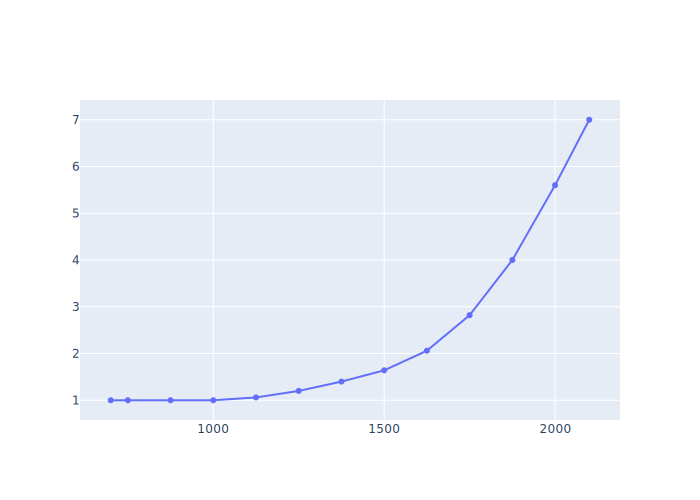

In [14]:
nom_dia_m = 0.25
pump_height_m = 2
_, inner_dia_m, _, _ = nearest_pipe(Di=nom_dia_m, schedule=schedule)
k_fitting_suction = 1.5
pipe_section_area_m2 = inner_dia_m**2 * np.pi / 4
length_suction_m = 5
vapor_pressure_pa = fluid.bubble_point_at_temperature(20).pressure
rho_g = fluid.density * gravitational_acc_m2_per_s
head_outlet = (2e5 + 1e5) / rho_g
vol_flow_array_for_npsh_r_m3_per_h = np.array([
    700, 750, 875, 1000, 1125, 1250, 1375, 1500, 1625, 1750, 1875, 2000, 2100
])
npsh_r_array_m = np.array([
    1.0, 1.0, 1.0, 1.0, 1.06, 1.2, 1.4, 1.64, 2.06, 2.82, 4.0, 5.6, 7.0
])
interpolate_function_for_npsh_r = interp1d(x=vol_flow_array_for_npsh_r_m3_per_h, y=npsh_r_array_m)

fig = make_subplots()
fig.add_scatter(x=vol_flow_array_for_npsh_r_m3_per_h, y=npsh_r_array_m)
fig.show(renderer="svg")

In [15]:

# First, we will define a function that calculates the suction head and NPSH available
def get_suction_head(water_depth_m: float, vol_flow_m3_per_s: float) -> float:
    pressure_tank = 1e5
    velocity_m_per_s = vol_flow_m3_per_s / pipe_section_area_m2
    pressure_drop_fitting = core.dP_from_K(
        K=k_fitting_suction, rho=fluid.density, V=velocity_m_per_s
    )
    pressure_drop_pipe = friction.one_phase_dP(
        m=vol_flow_m3_per_s * fluid.density,
        rho=fluid.density,
        mu=fluid.dynamic_viscosity,
        D=inner_dia_m,
        roughness=roughness,
        L=length_suction_m,
    )
    head_loss = (pressure_drop_pipe + pressure_drop_fitting) / rho_g
    return pressure_tank / rho_g + water_depth_m - pump_height_m - head_loss

def get_npsh_available(water_depth_m: float, vol_flow_m3_per_s: float) -> float:
    return get_suction_head(water_depth_m=water_depth_m, vol_flow_m3_per_s=vol_flow_m3_per_s) \
           - vapor_pressure_pa / rho_g

# Define function to calculate pump flow for given discharge head
interpolate_vol_flow_from_head = interp1d(
    x=df["Head [m]"], y=df["Flow [m3/h]"] / 3600, kind="cubic", fill_value="extrapolate"
)
def get_pump_vol_flow_m3_per_s(discharge_head_m: float, water_depth_m: float) -> float:
    def function_to_solve(vol_flow_m3_per_s: float) -> float:
        differential_head = discharge_head_m - get_suction_head(
            water_depth_m=water_depth_m,
            vol_flow_m3_per_s=vol_flow_m3_per_s
        )
        return vol_flow_m3_per_s - get_flow_pump_m3_per_s(head_m=differential_head)
    initial_value = interpolate_vol_flow_from_head(discharge_head_m - water_depth_m + pump_height_m)
    sol = root_scalar(f=function_to_solve, x0=initial_value, x1=initial_value*1.05)
    if sol.converged:
        return sol.root
    raise ValueError(f"The solution didn't converger for {discharge_head_m}m head and water depth {water_depth_m}m")

# Define function to calculate the flow in the system depending on the water depth
def get_system_vol_flow_m3_per_s(water_depth_m: float) -> float:
    def function_to_solve(vol_flow_m3_per_s: float) -> float:
        head_loss_output_m = get_head_loss_with_flow_input(
            flow_m3_per_s=vol_flow_m3_per_s, nom_dia_m=nom_dia_m
        )
        discharge_head_pump_m = head_loss_output_m + head_outlet
        # pump_vol_flow_m3_per_s = get_flow_pump_m3_per_s(discharge_head_pump_m)
        pump_vol_flow_m3_per_s = get_pump_vol_flow_m3_per_s(
            discharge_head_m=discharge_head_pump_m,
            water_depth_m=water_depth_m
        )
        return vol_flow_m3_per_s - pump_vol_flow_m3_per_s
    initial_value = 1600 / 3600
    sol = root_scalar(f=function_to_solve, x0=initial_value, x1=initial_value*1.05)
    if sol.converged:
        return sol.root
    raise ValueError(f"The solution didn't converge for {water_depth_m}m")

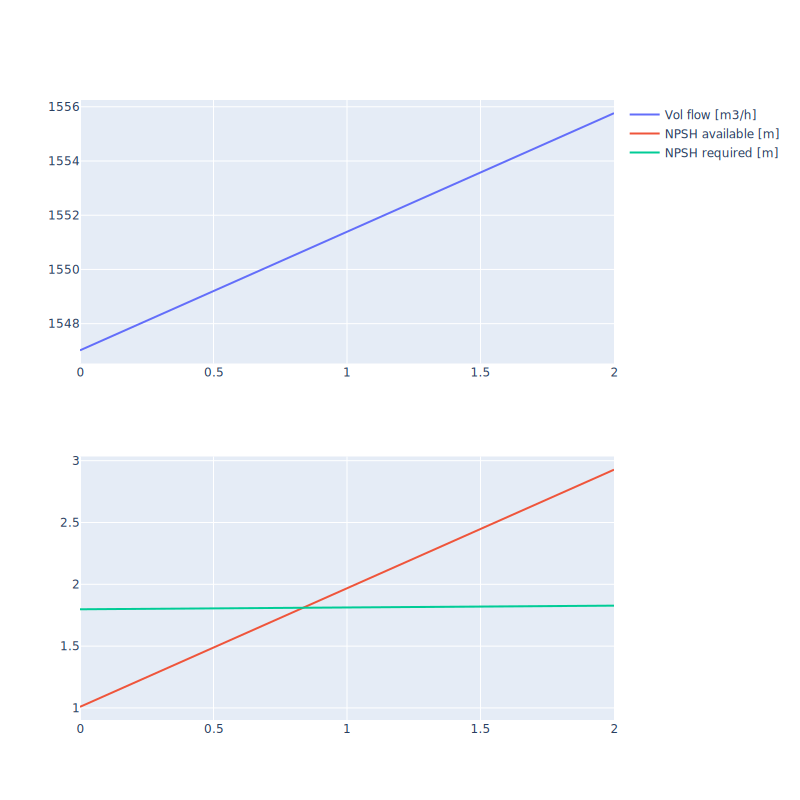

In [16]:
water_depth_array_m = np.linspace(0, 2, 21)
vol_flow_array_m3_per_s = np.array([
    get_system_vol_flow_m3_per_s(each_depth) for each_depth in water_depth_array_m
])
npsh_available = np.array([
    get_suction_head(water_depth_m=each_depth, vol_flow_m3_per_s=each_flow)
    for each_depth, each_flow in zip(water_depth_array_m, vol_flow_array_m3_per_s)
])
npsh_required = interpolate_function_for_npsh_r(vol_flow_array_m3_per_s * 3600)
fig = make_subplots(cols=1, rows=2)
fig.add_scatter(x=water_depth_array_m, y=vol_flow_array_m3_per_s * 3600, col=1, row=1, name="Vol flow [m3/h]")
fig.add_scatter(x=water_depth_array_m, y=npsh_available, col=1, row=2, name="NPSH available [m]")
fig.add_scatter(x=water_depth_array_m, y=npsh_required, col=1, row=2, name="NPSH required [m]")
fig.update_layout(height=800, width=800)
fig.show(renderer="svg")

### What will be the method to lower this limit to ensure to pump out most of the water in the tank?














================= Answer =====================
Reducing the flow by throttling the pump will enable the pump to lower the required NPSH.
This can be simulated by increasing the K value of the outlet.

In [17]:
def get_system_vol_flow_m3_per_s(
        water_depth_m: float,
        additional_k_valve: float,
        initial_value_m3_per_h: float
) -> float:
    def function_to_solve(vol_flow_m3_per_s: float) -> float:
        head_loss_output_m = get_head_loss_with_flow_input(
            flow_m3_per_s=vol_flow_m3_per_s, nom_dia_m=nom_dia_m
        )
        velocity = vol_flow_m3_per_s / pipe_section_area_m2
        additional_head_loss_valve_m = core.head_from_K(
            K=additional_k_valve, V=velocity, g=gravitational_acc_m2_per_s
        )
        discharge_head_pump_m = head_loss_output_m + head_outlet + additional_head_loss_valve_m
        # pump_vol_flow_m3_per_s = get_flow_pump_m3_per_s(discharge_head_pump_m)
        pump_vol_flow_m3_per_s = get_pump_vol_flow_m3_per_s(
            discharge_head_m=discharge_head_pump_m,
            water_depth_m=water_depth_m
        )
        return vol_flow_m3_per_s - pump_vol_flow_m3_per_s
    initial_value = initial_value_m3_per_h / 3600
    sol = root_scalar(f=function_to_solve, x0=initial_value, x1=initial_value*1.05)
    if sol.converged:
        return sol.root
    raise ValueError(f"The solution didn't converge for {water_depth_m}m")

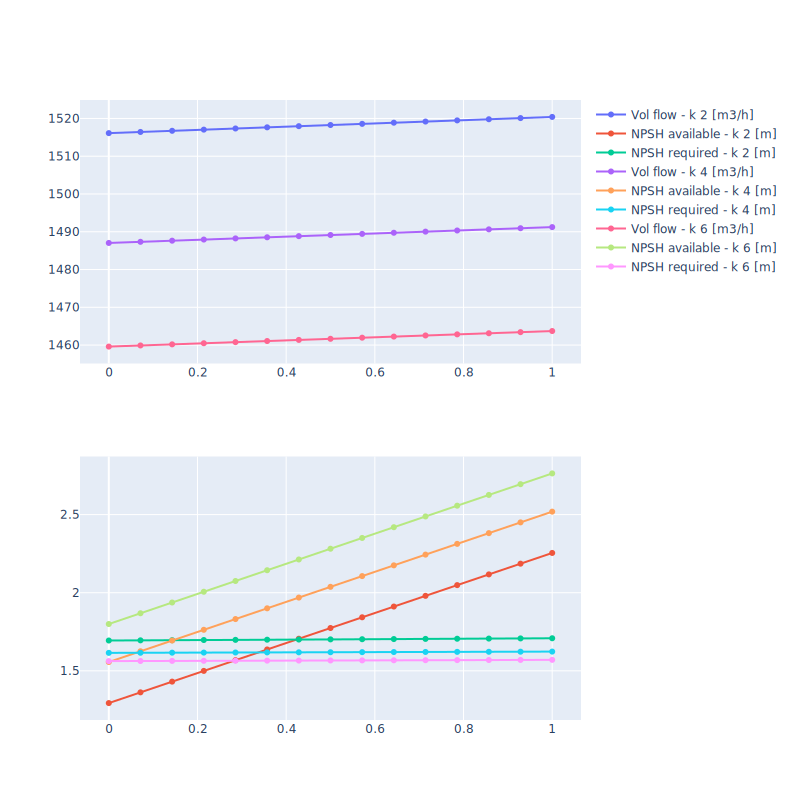

In [18]:
k_values = [2, 4, 6]
initial_values = [1500, 1500, 1500]

fig = make_subplots(cols=1, rows=2)
for k_valve, initial_value in zip(k_values, initial_values):
    water_depth_array_m = np.linspace(0, 1.0, 15)
    vol_flow_array_m3_per_s = np.array([
        get_system_vol_flow_m3_per_s(
            water_depth_m=each_depth,
            additional_k_valve=k_valve,
            initial_value_m3_per_h=initial_value
        ) for each_depth in water_depth_array_m
    ])
    npsh_available = np.array([
        get_suction_head(water_depth_m=each_depth, vol_flow_m3_per_s=each_flow)
        for each_depth, each_flow in zip(water_depth_array_m, vol_flow_array_m3_per_s)
    ])
    npsh_required = interpolate_function_for_npsh_r(vol_flow_array_m3_per_s * 3600)
    fig.add_scatter(x=water_depth_array_m, y=vol_flow_array_m3_per_s * 3600, col=1, row=1, name=f"Vol flow - k {k_valve} [m3/h]")
    fig.add_scatter(x=water_depth_array_m, y=npsh_available, col=1, row=2, name=f"NPSH available - k {k_valve} [m]")
    fig.add_scatter(x=water_depth_array_m, y=npsh_required, col=1, row=2, name=f"NPSH required - k {k_valve}  [m]")
    fig.update_layout(height=800, width=800)
fig.show(renderer="svg")